# Random Forest Classification (RFC) - vegetation 
* SACFOR and Reflectance
* aided by: 
https://ceholden.github.io/open-geo-tutorial/python/chapter_5_classification.html

In [338]:
import os

import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio import sample
from rasterio.warp import reproject, Resampling
import rasterio.mask
from rasterio.plot import show
from skimage import exposure
from shapely.geometry import box

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches

import contextily as ctx

# Modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error,make_scorer

### Change working directory

In [182]:
os.chdir('/Users/Meredith/Library/CloudStorage/GoogleDrive-meredith.mcpherson@umb.edu/.shortcut-targets-by-id/1PJamAGTknM_kuVq8M53Xo4cAlWzDOk6I/kelp_murep/')

### Datasets

In [369]:
# load the sacfor training data shape file
sacfor = gpd.read_file('sidescan_surveys/gooseberries_sacfor_raster_samples/gooseberries_sacfor_raster_samples_corr.shp')

sacfor['SACFOR_veg'] = sacfor['SACFOR_veg'].replace('s', 'S')

# Create a new column based on the elevations
sacfor['depth criteria'] = np.where(sacfor['Elev(m)'] >= z_thresh, 'shallow', 'deep')

# create a new column based on presence and absence of kelp via some SACFOR % cover threshold
sacfor['kelp_pres/abs'] = np.where((sacfor['kel #'] == 4) | (sacfor['kel #'] == 5),1,0)
sacfor['veg_pres/abs'] = np.where((sacfor['veg #corr'] == 4) | (sacfor['veg #corr'] == 5),1,0)

# bathymetry tif file
bathy_file = 'sidescan_surveys/SALEM_Raster/Gooseberry_Bathy.tif'
bathy_reproject_file = 'rs_imagery_processing/classification/random_forest/bathy_reprojected_headwall.tif'
# hyperspectral tif file
#img_file = '/Volumes/Mere/UMB/rs_imagery_processing/Headwall/merged/rasterio_native_clean_1m.tif'
img_file = 'rs_imagery_processing/Headwall/merged/rasterio_1m_smoothed_deglinted_clean.tif'




### Reproject Bathymetry file to match Headwall

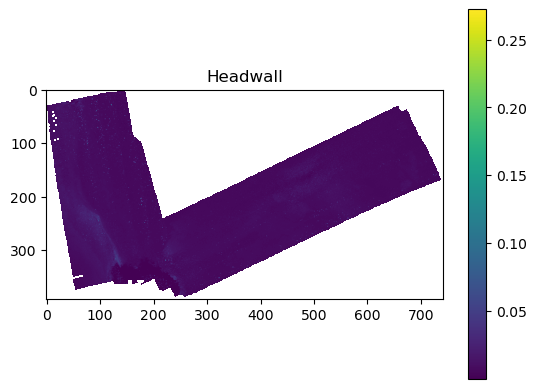

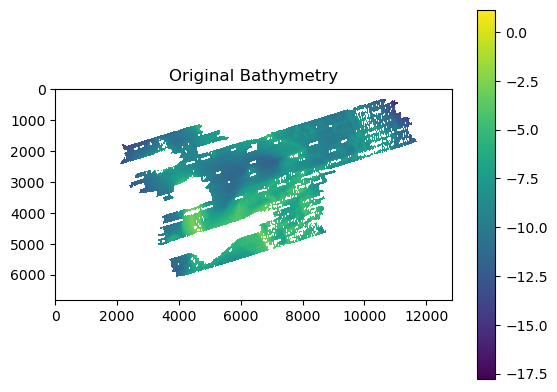

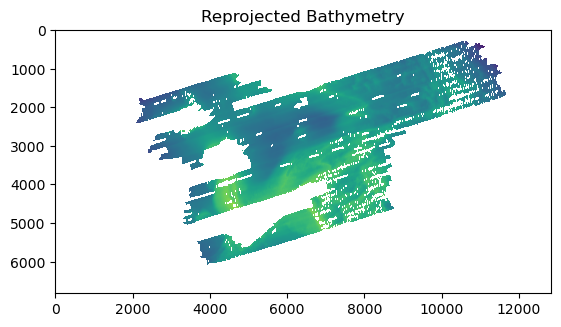

In [286]:
# Load the hyperspectral data 
with rio.open(img_file) as src:
    arr = src.read()
    meta = src.meta

    plt.imshow(arr[100,:,:])
    plt.colorbar()
    plt.title('Headwall')
    plt.show()
    
    # Load the bathymetry data 
    with rio.open(bathy_file) as bathy_src:
        bathy_arr = bathy_src.read(1)
        bathy_arr[bathy_arr==-3.4028234663852886e+38] = np.nan
        
        plt.imshow(bathy_arr[:,:])
        plt.colorbar()
        plt.title('Original Bathymetry')
        plt.show()
        
        bathy_meta = bathy_src.meta
        
        # Create a new raster file as the destination dataset
        dst_meta = meta.copy()

        with rio.open('bathy_reprojected_headwall.tif', 'w', **dst_meta) as dst:
            # Reproject the bathymetry raster to match the CRS of the hyperspectral data
            reproject(
                bathy_arr,
                destination=rio.band(dst, 1),
                src_crs=bathy_meta['crs'],
                dst_crs=meta['crs'],
                src_transform=bathy_meta['transform'],
                dst_transform=meta['transform'],
                resampling=Resampling.nearest)

# check reprojected bathymetry
with rio.open('bathy_reprojected_headwall.tif') as bathy_reproj:
    reproj_arr = bathy_reproj.read(1)
    reproj_arr[reproj_arr==-3.4028234663852886e+38] = np.nan

    fig,ax = plt.subplots()
    show(bathy_arr, ax=ax)
    #sacfor_headwall.plot(ax=ax, column='kel #', markersize=10)
    #plt.colorbar()
    plt.title('Reprojected Bathymetry')
    plt.show()  
                

### Subset and mask deep water in the Headwall imagery

1. Crop the bathymetry file to the headwall bounding box
2. Crop the sacfor shapefile to the headwall bounding box
3. Mask deeper than the chosen depth threshold
4. Crop everything to the smaller subset area in north gooseberries

In [819]:
z_thresh = -5


# Define the bounding box to crop to (xmin, ymin, xmax, ymax)
gb_subset_bbox = [258025, 919500, 258150, 919650]

In [820]:
# Crop and mask everything

# Load the hyperspectral data 
with rio.open(img_file) as src:
    arr = src.read()
    
    # HEADWALL masking to nan values
    arr[arr == -9999] = np.nan
    arr[arr < 0] = np.nan
    
    meta = src.meta
    
    # convert the sacfor dataframe to the hyperspectral crs
    sacfor = sacfor.to_crs(src.crs)
    
    # Open the reprojected bathymetry file in read mode and read the data into bathy_arr
    with rio.open(bathy_reproject_file) as reproj_bathy:
        bathy_arr = reproj_bathy.read(1)

        bathy_arr[bathy_arr==-3.4028234663852886e+38] = np.nan

        # ------ HEADWALL BBOX
        # get the bounding corners and create window for the headwall src
        headwall_bbox = src.bounds
        headwall_bbox = [headwall_bbox.left, headwall_bbox.bottom, headwall_bbox.right, headwall_bbox.top]
           
        headwall_window = rio.windows.from_bounds(*headwall_bbox, transform=meta['transform'])

        # crop the bathymetry data to the headwall bbox
        bathy_headwall = reproj_bathy.read(window=headwall_window)[0]
        bathy_headwall[bathy_headwall == -3.4028234663852886e+38] = np.nan

        # crop sacfor to headwall bbox
        sacfor_headwall = sacfor[sacfor.within(box(*headwall_bbox))]

        # Mask the headwall array where the values are greater than -4 or nan
        nanmask = np.isnan(bathy_arr)
        arr_headwall_nanmasked = np.ma.masked_array(arr, mask=np.tile(nanmask, (arr.shape[0], 1, 1)))

        zmask = bathy_arr < z_thresh
        arr_headwall_zmasked = np.ma.masked_array(arr_headwall_nanmasked, mask=np.tile(zmask, (arr.shape[0], 1, 1)))

        

        
        # ----- GOOSEBERRY SUBSET BBOX
        # create window for subset
        subset_window = rio.windows.from_bounds(*gb_subset_bbox, transform=meta['transform'])

        # crop the headwall array to the subset bbox
        arr_subset = src.read(window=subset_window)
        
        # crop the bathymetry data to the subset bbox
        bathy_subset = reproj_bathy.read(window=subset_window)[0]
        bathy_subset[bathy_subset == -3.4028234663852886e+38] = np.nan
        
        
        # Filter sacfor points within the subset bounding box
        sacfor_subset = sacfor[sacfor.within(box(*gb_subset_bbox))]

        # sort out deep elevation in SACFOR
        sacfor_subset_filt = sacfor_subset[sacfor_subset['Elev(m)']>=z_thresh]


        # Mask the subset array where the values are greater than -4 or nan

        nanmask = np.isnan(bathy_subset)
        arr_subset_nanmasked = np.ma.masked_array(arr_subset, mask=np.tile(nanmask, (arr_subset.shape[0], 1, 1)))
        
        zmask = bathy_subset < z_thresh
        arr_subset_zmasked = np.ma.masked_array(arr_subset_nanmasked, mask=np.tile(zmask, (arr_subset.shape[0], 1, 1)))

        #bathy_subset_zmasked = np.ma.masked_array(bathy_subset, mask=np.tile(zmask,(bathy_subset.shape,1)))

Rasterize the SACFOR for RF runs

In [822]:
# rasterize the sacfor gpd to the cropped bounding box based on the 'sacfor_veg target
# as the values in the sacfor raster
out_meta = src.meta.copy()
out_meta.update({
    "height": arr_subset.shape[1],
    "width": arr_subset.shape[2],
    "transform": rio.windows.transform(subset_window, src.transform),
    "dtype": 'int32'
})

data = sacfor_subset_filt

# BINARY SACFOR 
sacfor_raster_binveg = rio.features.rasterize(
    [(geom, val) for geom, val in zip(data.geometry, data['veg_pres/abs'])],
    out_shape=(arr_subset.shape[1], arr_subset.shape[2]),
    transform=out_meta["transform"],
    fill=-999.0,
    all_touched=True,
    dtype='int32'
)
sacfor_raster_binkelp = rio.features.rasterize(
    [(geom, val) for geom, val in zip(data.geometry, data['kelp_pres/abs'])],
    out_shape=(arr_subset.shape[1], arr_subset.shape[2]),
    transform=out_meta["transform"],
    fill=-999.0,
    all_touched=True,
    dtype='int32'
)

# FULL SACFOR 
sacfor_raster_veg = rio.features.rasterize(
    [(geom, val) for geom, val in zip(data.geometry, data['veg #corr'])],
    out_shape=(arr_subset.shape[1], arr_subset.shape[2]),
    transform=out_meta["transform"],
    fill=-999.0,
    all_touched=True,
    dtype='int32'
)

sacfor_raster_veg_nocor = rio.features.rasterize(
    [(geom, val) for geom, val in zip(data.geometry, data['veg #'])],
    out_shape=(arr_subset.shape[1], arr_subset.shape[2]),
    transform=out_meta["transform"],
    fill=-999.0,
    all_touched=True,
    dtype='int32'
)
sacfor_raster_kelp = rio.features.rasterize(
    [(geom, val) for geom, val in zip(data.geometry, data['kel #'])],
    out_shape=(arr_subset.shape[1], arr_subset.shape[2]),
    transform=out_meta["transform"],
    fill=-999.0,
    all_touched=True,
    dtype='int32'
)

# plot the rasters next to each other
#sacfor_raster_kelp = np.where(sacfor_raster_kelp==-999.0, np.nan, sacfor_raster_kelp)
# plt.imshow(sacfor_raster_kelp)
# plt.colorbar()
# plt.show()

#sacfor_raster_veg = np.where(sacfor_raster_veg==-999.0, np.nan, sacfor_raster_veg)
# plt.imshow(sacfor_raster_veg)
# plt.colorbar()
# plt.show()

Figure for entire Gooseberry Headwall area with SACFOR overlayed

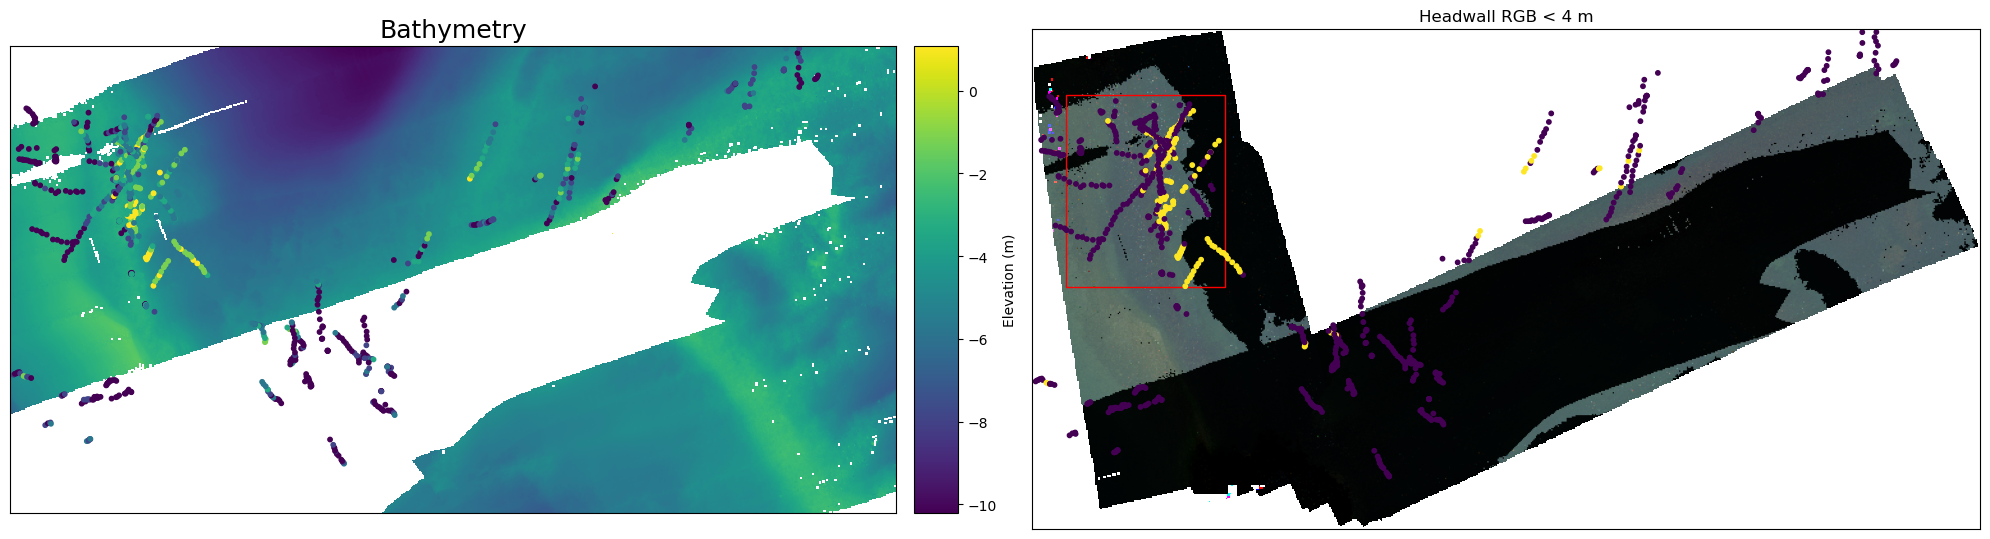

In [823]:
# create RGB

corr_rgb = arr_headwall_zmasked[[114, 75, 25], :, :]

# Apply contrast stretching to improve the visibility
# stretched = np.zeros_like(corr_rgb)
# for i in range(3):
#     stretched[i] = exposure.rescale_intensity(corr_rgb[i])

# adjust the brightness of the image

gamma_corrected = exposure.adjust_gamma(corr_rgb, gamma=0.23)


# Plot the figure
fig1, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 20))
     
# Overlay the red box on the hyperspectral subplot
rect = patches.Rectangle((gb_subset_bbox[0], gb_subset_bbox[1]), gb_subset_bbox[2] - gb_subset_bbox[0], gb_subset_bbox[3] - gb_subset_bbox[1],
                         linewidth=1, edgecolor='r', facecolor='none')
ax2.add_patch(rect)

rio_im = show(bathy_headwall,transform = rio.windows.transform(headwall_window, reproj_bathy.transform),ax=ax1)
im = rio_im.get_images()[0]
sacfor_headwall.plot(ax=ax1, column='kel #', markersize=10)
ax1.set_title('Bathymetry', fontsize = 18)
ax1.set_xticks([])
ax1.set_yticks([])

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad='2%')
cbar = fig1.colorbar(im, cax=cax)
cbar.set_label('Elevation (m)')


show(gamma_corrected, transform = rio.windows.transform(headwall_window, src.transform),ax=ax2)
ax2.set_title('Headwall RGB < 4 m')
sacfor_headwall.plot(ax=ax2, column='kelp_pres/abs', markersize=10)
ax2.set_xticks([])
ax2.set_yticks([])

# plt.legend(loc='lower right',
# fontsize = 20,
# labelcolor='w',
# facecolor = 'black')

fig1.tight_layout()
plt.show()

Figure for subset of Gooseberry Headwall area

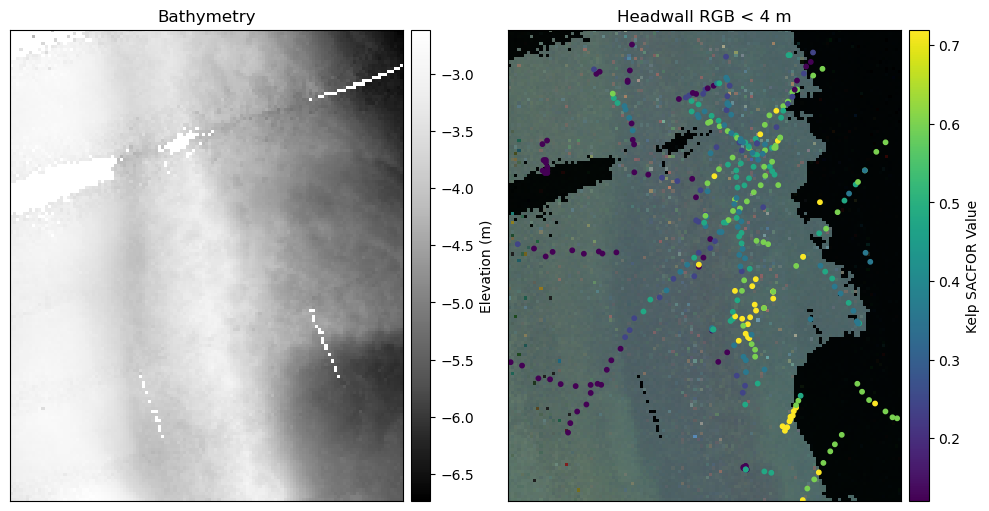

In [824]:
# create RGB

corr_rgb = arr_subset_zmasked[[114, 75, 25], :, :]

# Apply contrast stretching to improve the visibility
# stretched = np.zeros_like(corr_rgb)
# for i in range(3):
#     stretched[i] = exposure.rescale_intensity(corr_rgb[i])

# adjust the brightness of the image

gamma_corrected = exposure.adjust_gamma(corr_rgb, gamma=0.23)

fig2, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 10))

rio_im = show(bathy_subset_crop, transform = rio.windows.transform(subset_window, reproj_bathy.transform), ax=ax1,cmap='Greys_r')
im = rio_im.get_images()[0]
ax1.set_title('Bathymetry')
ax1.set_xticks([])
ax1.set_yticks([])

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad='2%')
cbar = fig1.colorbar(im, cax=cax)
cbar.set_label('Elevation (m)')

rgb_im = show(gamma_corrected, transform = rio.windows.transform(subset_window, src.transform), ax=ax2)
im = rgb_im.get_images()[0]
ax2.set_title('Headwall RGB < 4 m')
sacfor_subset.plot(ax=ax2, column='kel #', markersize=10)

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad='2%')
cbar = fig1.colorbar(im, cax=cax)
cbar.set_label('Kelp SACFOR Value')


ax2.set_xticks([])
ax2.set_yticks([])

fig2.tight_layout()
plt.show()


### Dimensionality Reduction - PCA on Headwall 

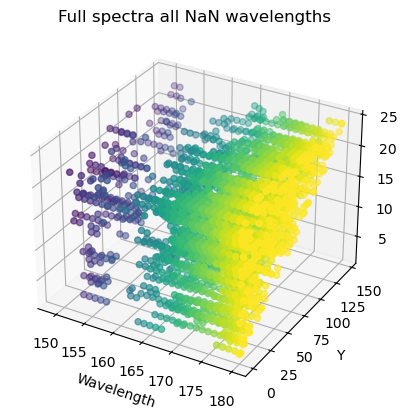

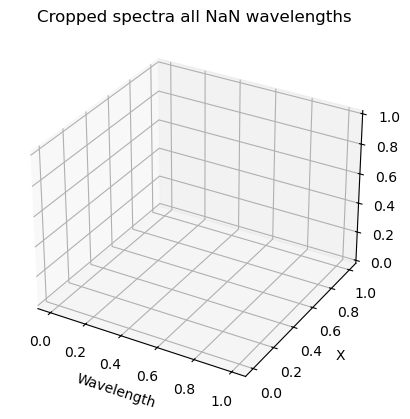

In [825]:
#### check for nans in hyperspectral data - cannot have for PCA
arr_test = arr_subset_zmasked[25:148,:,:]

# create a boolean mask for NaN values
nan_mask = np.isnan(arr_subset_masked)
nan_mask_test = np.isnan(arr_test)

# find the indices of NaN values
nan_indices = np.argwhere(nan_mask)
nan_indices_test = np.argwhere(nan_mask_test)

# visualize the NaN values using a scatter plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(nan_indices[:, 0], 
           nan_indices[:, 1], 
           nan_indices[:, 2], 
           c=nan_indices[:, 0])
ax.set_xlabel('Wavelength')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Full spectra all NaN wavelengths')
plt.show()
                               
                              
fig1 = plt.figure()
ax = fig1.add_subplot(projection='3d')                               
ax.scatter(nan_indices_test[:, 0], 
           nan_indices_test[:, 1], 
           nan_indices_test[:, 2], 
           c=nan_indices_test[:, 0]) 
ax.set_xlabel('Wavelength')
ax.set_ylabel('X')
ax.set_zlabel('Y')
plt.title('Cropped spectra all NaN wavelengths')
plt.show()


In [826]:
# Crop the wavelengths of the image array to 450 - 728 nm
# removing NaNs for PCA
arr_clean = arr_test

# Convert to 2D numpy array
flattened_data = np.transpose(arr_clean, (1, 2, 0)).reshape(-1, arr_clean.shape[0])

# Perform PCA on the flattened data
pca = PCA(n_components = 40)
pca.fit(flattened_data)

# Transform the data into the PCA space
pca_data_flattened = pca.transform(flattened_data)

# Reshape the PCA data back into its original shape
pca_data = pca_data_flattened.reshape(arr_clean.shape[1], arr_clean.shape[2],-1)

#arr_clean_pca = arr_clean.reshape(arr_clean.shape[1], arr_clean.shape[2],arr_clean.shape[0])
arr_clean_nopca = np.transpose(arr_clean, (1, 2, 0))

# # Save the PCA data to disk
# with rio.open(pca_file, 'w', **meta) as dst:
#     dst.write(pca_data)


### Pairing X and y data

In [830]:
sacfor_type = sacfor_raster_kelp

n_samples = (sacfor_type >= 0).sum()
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(sacfor_type[sacfor_type >= 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))
# We will need a "X" matrix containing our features, and a "y" array containing our labels
#     These will have n_samples rows
#     In other languages we would need to allocate these and them loop to fill them, but NumPy can be faster

X = arr_clean_nopca[sacfor_type >= 0,:]
#X = pca_data[sacfor_type >= 0,:]
y = sacfor_type[sacfor_type >= 0]

train_X,val_X,train_y,val_y=train_test_split(X,y,test_size=0.2,random_state=1)

print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

We have 272 samples
The training data include 6 classes: [0 1 2 3 4 5]
Our X matrix is sized: (272, 123)
Our y array is sized: (272,)


### Hypertuning Random Forest Model to dataset
https://www.kaggle.com/code/virajbagal/eda-xgb-random-forest-parameter-tuning-hyperopt/notebook
https://github.com/hyperopt/hyperopt-sklearn
https://machinelearningmastery.com/hyperopt-for-automated-machine-learning-with-scikit-learn/

In [842]:
rf_model = HyperoptEstimator(classifier=random_forest_classifier('RF1'),
                              preprocessing=any_preprocessing('pre'))


rf_model.fit(train_X,train_y)

100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  2.70s/trial, best loss: 0.6818181818181819]


In [843]:
acc = rf_model.score(val_X,val_y) * 100
print(f'Accuracy: {acc:.3f}%')

print(rf_model.best_model())

Accuracy: 36.364%
{'learner': RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=4, max_features=0.14204273799356526,
                       max_leaf_nodes=15, n_estimators=78, n_jobs=1,
                       random_state=1, verbose=False), 'preprocs': (StandardScaler(with_mean=False, with_std=False),), 'ex_preprocs': ()}


## Random Forest Model Runs with no hypertuning

In [836]:
# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=500, max_features=0.33, random_state=1, oob_score=True)

# Fit our model to training data
rf = rf.fit(train_X, train_y)



What is the RF model accuracy?

In [837]:
# Validation score
score = rf.score(val_X,val_y) * 100
print(f'Validation Accuracy: {score:.2f}%')

# out-of-box score - subset of training set
oob=rf.oob_score_ * 100
print(f'\nOOB Accuracy: {oob:.2f}% \n')

# mean squared error:
# Predict X values
df = pd.DataFrame()
df['truth'] = val_y
df['predict'] = rf.predict(val_X)

# Cross-tabulate predictions
print(pd.crosstab(df['truth'], df['predict'], margins=True))

score_rf = mean_squared_error(df['predict'],df['truth'])

print(f'\nMSE: {score_rf:.2f}')

Validation Accuracy: 27.27%

OOB Accuracy: 27.65% 

predict  0  1   2   3  4  5  All
truth                           
0        4  2   2   3  1  0   12
1        1  1   1   1  0  0    4
2        1  2   2   2  2  2   11
3        1  0   5   3  2  1   12
4        1  1   2   3  1  1    9
5        1  1   0   1  0  4    7
All      9  7  12  13  6  8   55

MSE: 3.55


In [ ]:
# band importance
bands = list(range(1, arr_clean_pca.shape[2]))

for b, imp in zip(bands, rf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

# plot band imporance

Predicting the rest of the image

In [838]:
# Take our full image, ignore the Fmask band, and reshape into long 2d array (nrow * ncol, nband) for classification
# use flattened_data var from above

# Now predict for each pixel
class_prediction = rf.predict(flattened_data)
#class_prediction = rf.predict(pca_data_flattened)

# Reshape our classification map
class_prediction_reshape = class_prediction.reshape(arr_clean[0,:, :].shape)

# mask
class_prediction_mask = np.ma.masked_array(class_prediction_reshape, mask=np.tile(zmask, (1, 1, 1)))

Plot the classification raster

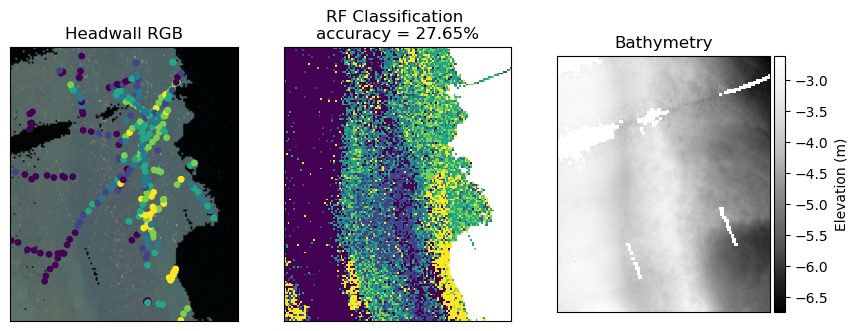

In [841]:
# See https://github.com/matplotlib/matplotlib/issues/844/
n = class_prediction_mask.max()

# Now show the classmap next to the image
# set up gamma corrected rgb for plotting

corr_rgb = arr_clean[[89, 44, 0], :, :]
gamma_corrected = exposure.adjust_gamma(corr_rgb, gamma=0.23)

# plot the hyperspectral and rasterized sacfor next to each other

fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, figsize=(10, 10))

show(gamma_corrected, 
     transform = rio.windows.transform(subset_window, src.transform), 
     ax=ax1)
ax1.set_title('Headwall RGB')
sacfor_subset_filt.plot(ax=ax1, 
             c=sacfor_subset_filt['kel #'], 
             markersize=15)
ax1.set_xticks([])
ax1.set_yticks([])

im = ax2.imshow(class_prediction_mask, 
           cmap='viridis', 
           interpolation='none')
ax2.set_title(f'RF Classification \naccuracy = {oob:.2f}%')
ax2.set_xticks([])
ax2.set_yticks([])

#resize the colorbar to match the size of ax2
# divider = make_axes_locatable(ax2)
# cax = divider.append_axes("right", size="5%", pad=0.1)
# cbar = plt.colorbar(im, cax=cax, cmap='viridis')
# cbar.ax.tick_params(labelsize=10)
# cbar.set_ticks([0,1,2,3,4,5])
# cbar.set_label('SACFOR')

rio_im = show(bathy_subset_crop, transform = rio.windows.transform(subset_window, reproj_bathy.transform), ax=ax3,cmap='Greys_r')
im = rio_im.get_images()[0]
ax3.set_title('Bathymetry')
ax3.set_xticks([])
ax3.set_yticks([])

divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad='2%')
cbar = fig1.colorbar(im, cax=cax)
cbar.set_label('Elevation (m)')


plt.show()

### Output classification as a raster

### Testing Optimization of classifier with hyperopt-sklearn

https://github.com/hyperopt/hyperopt-sklearn

In [575]:
from hyperopt import tpe,hp,Trials
from hyperopt.fmin import fmin
from hpsklearn import HyperoptEstimator, any_classifier, any_preprocessing, random_forest_classifier, xgboost_classification

In [578]:

model = HyperoptEstimator(classifier=any_classifier('clf'),
                          preprocessing=any_preprocessing('pre'),
                         algo=tpe.suggest,trial_timeout=300)

model.fit(train_X,train_y)
acc = model.score(val_X,val_y)
print(f'Accuracy: {acc:.3f}%')

print(model.best_model())

  0%|                                                                       | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/Caskroom/miniforge/base/envs/geospatial/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


 88%|██████████████████████████████████████████████████████████████▏        | 7/8 [00:00<?, ?trial/s, best loss=?]

/usr/local/Caskroom/miniforge/base/envs/geospatial/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  1.05s/trial, best loss: 0.6799999999999999]


/usr/local/Caskroom/miniforge/base/envs/geospatial/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 0.333%
{'learner': AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
                   learning_rate=0.012491443356644738, n_estimators=947,
                   random_state=2), 'preprocs': (StandardScaler(with_mean=False, with_std=False),), 'ex_preprocs': ()}


In [579]:
rf_model = HyperoptEstimator(classifier=random_forest_classifier('RF1'),
                              preprocessing=any_preprocessing('pre'))


rf_model.fit(train_X,train_y)
acc = rf_model.score(val_X,val_y)
print(f'Accuracy: {acc:.3f}%')

print(rf_model.best_model())

100%|█████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  1.31s/trial, best loss: 0.62]
Accuracy: 0.302%
{'learner': RandomForestClassifier(criterion='entropy', max_features=0.9417750426072492,
                       min_impurity_decrease=0.05, n_estimators=20, n_jobs=1,
                       random_state=3, verbose=False), 'preprocs': (PCA(n_components=4),), 'ex_preprocs': ()}


In [ ]:
xg_model = HyperoptEstimator(classifier=xgboost_classification('xg'),
                              preprocessing=any_preprocessing('pre'))


xg_model.fit(train_X,train_y)
acc = xg_model.score(val_X,val_y)
print(f'Accuracy: {acc:.3f}%')

print(xg_model.best_model())